In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# %reload_ext autoreload

In [55]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import skimage as sk
import numpy as np
import homography, rectification, filters, my_types, utils

# input files

In [180]:
DATA = Path("data")
OUTDIR = Path("output")

In [186]:
name  = "car"
im1_name = DATA / (name + "1.jpg")
im2_name = DATA / (name + "2.jpg")

In [187]:
plane_name = DATA / (name + "_plane.pkl")

warp1_name = DATA / (im1_name.stem + "_w.jpg")
warp2_name = DATA / (im2_name.stem + "_w.jpg")

pts1_name = DATA / (im1_name.stem + "_w.pkl")
pts2_name = DATA / (im2_name.stem + "_w.pkl")

In [188]:
mosaic_name = OUTDIR / (name + "_mosaic.jpg")

# Pick Correspondences

In [189]:
im1 = utils.read_img(im1_name)
im2 = utils.read_img(im2_name)

In [235]:
try:
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
except:
    %matplotlib tk
    im1_pts = utils.pick_points(im1_name, 4)
    im2_pts = utils.pick_points(im2_name, 4)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)
    %matplotlib inline

In [236]:
im1_pts = im1_pts[:4]
im2_pts = im2_pts[:4]

In [237]:
h, w, c = im1.shape

num_pixels = 1600 * 1600
RESIZE = h * w > num_pixels

print(f"{RESIZE = }")
if RESIZE:
    r =  int(h * w / num_pixels)
    print("ratio = ", r)
    print("input shape = ", im1.shape)
    print("target shape = ", h / r, w / r)

RESIZE = False


In [238]:
if RESIZE:
    print("resizing...")
    im1 = sk.transform.resize(im1, (im1.shape[0] // r, im1.shape[1] // r), anti_aliasing=True)
    im2 = sk.transform.resize(im2, (im2.shape[0] // r, im2.shape[1] // r), anti_aliasing=True)
    im1_pts /= r
    im2_pts /= r

im1.shape

(750, 1000, 3)

In [239]:
# im2_pts = np.array([[336.39113737, 319.88745103], [157.08706851, 513.07312521], [469.42318845, 393.92267946], [121.22625474, 407.80428479]])

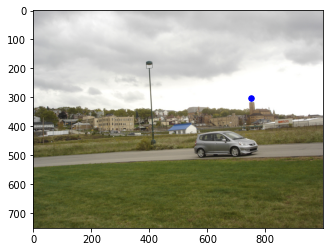

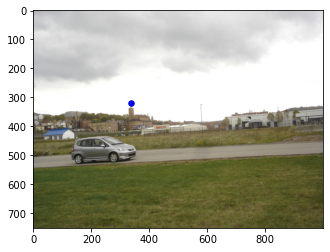

In [242]:
utils.plot_pts(im1, im1_pts[:1])
utils.plot_pts(im2, im2_pts[:1])

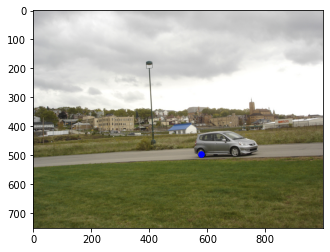

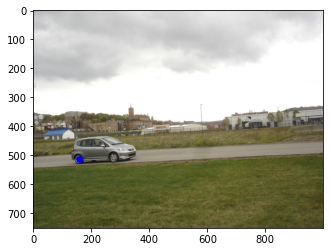

In [243]:
utils.plot_pts(im1, im1_pts[1:2])
utils.plot_pts(im2, im2_pts[1:2])

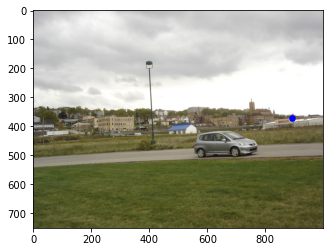

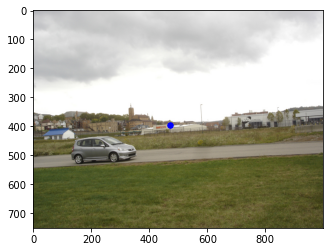

In [244]:
utils.plot_pts(im1, im1_pts[2:3])
utils.plot_pts(im2, im2_pts[2:3])

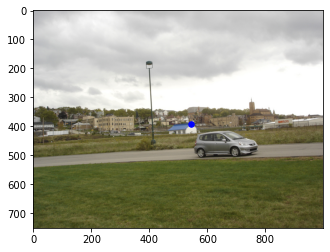

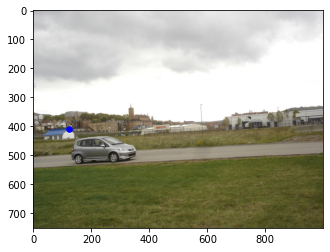

In [245]:
utils.plot_pts(im1, im1_pts[3:4])
utils.plot_pts(im2, im2_pts[3:4])

In [246]:
im1_pts

array([[751.92228244, 302.90525616],
       [577.05777687, 494.64265262],
       [893.04100624, 371.93071889],
       [543.31199509, 390.33750895]])

In [247]:
im2_pts

array([[336.39113737, 319.88745103],
       [157.08706851, 513.07312521],
       [469.42318845, 393.92267946],
       [121.22625474, 407.80428479]])

# Image Rectification

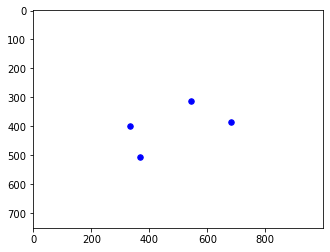

In [252]:
try:
    plane_pts = utils.load_points(plane_name)
except:
    %matplotlib tk
    plane_pts = utils.pick_points(im1, 4)
    %matplotlib inline
    # plane_pts = (im1_pts + im2_pts) / 2
    utils.save_points(plane_pts, plane_name)

if RESIZE:
    plane_pts /= r

canvas = np.ones_like(im1)
utils.plot_pts(canvas, plane_pts)

warping...
====target====
(805, 1095, 3)
1 1
804 1094
-47 -288
756 805
=====src=====
(750, 1000, 3)
0.07879618561894235 0.16143419978031762
749.0636796194494 999.1027306713212
=====interpolate=====


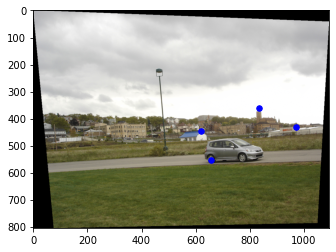

In [253]:
try:
    warp1 = utils.read_img(warp1_name)
    warp_pts1 = utils.load_points(pts1_name)

except:
    print("warping...")

    h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
    warp1, shift_pts1 = homography.inverse_warp(im1, h_matrix1)
    warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
    
    plt.imsave(warp1_name, warp1)
    utils.save_points(warp_pts1, pts1_name)

utils.plot_pts(warp1, warp_pts1)

warping...
====target====
(777, 1093, 3)
1 0
776 1092
-6 205
769 1297
=====src=====
(750, 1000, 3)
-0.22834821673852443 -0.30311825996645947
749.357696887198 999.4038806365903
=====interpolate=====


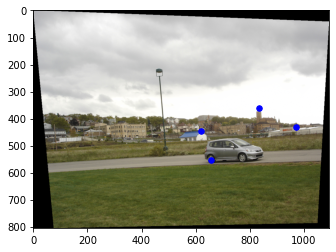

In [254]:
try:
    warp2 = utils.read_img(warp2_name)
    warp_pts2 = utils.load_points(pts2_name)

except:
    print("warping...")
    
    h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
    warp2, shift_pts2= homography.inverse_warp(im2, h_matrix2)
    warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)

    plt.imsave(warp2_name, warp2)
    utils.save_points(warp_pts2, pts2_name)

utils.plot_pts(warp1, warp_pts1)

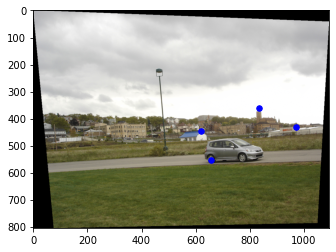

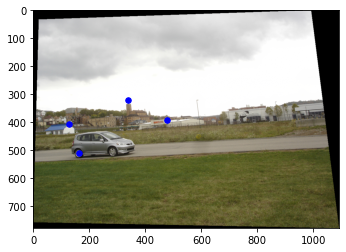

In [255]:
utils.plot_pts(warp1, warp_pts1)
utils.plot_pts(warp2, warp_pts2)

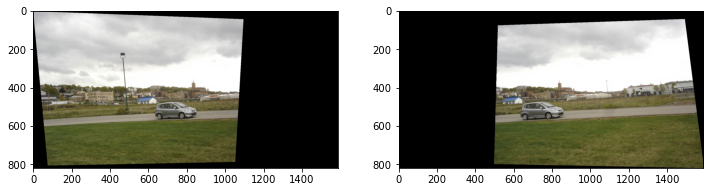

In [256]:
aligned1, aligned2 = rectification.align(warp1, warp2, warp_pts1, warp_pts2)
utils.show_two(aligned1, aligned2)

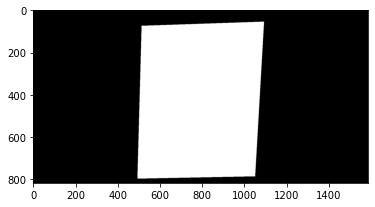

In [257]:
overlap = rectification.overlap(aligned1, aligned2)
plt.imshow(overlap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


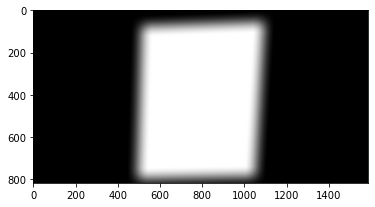

In [259]:
mask = filters.gauss_blur(overlap, kernel_size=100, sigma=30)
plt.imshow(mask)

In [260]:
blended = rectification.alpha_blend(aligned1, aligned2, mask)
blended.shape

(818, 1587, 3)

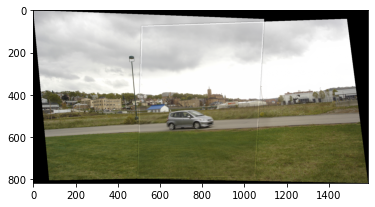

In [261]:
plt.imshow(blended)
plt.imsave(mosaic_name, blended)